In [100]:
from sympy import init_session
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as npy
import scipy as sp
%matplotlib widget
import os, glob, pathlib
from loky import get_reusable_executor
import dill as pickle
from sympy.utilities.lambdify import lambdastr
init_session()

IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



In [101]:
EXPRS = {}

In [102]:
def term_simplify(expr):
    run = 0
    for arg in expr.args:
        run += arg.simplify()
    return(run)
def term_multiply(expr, mult):
    run = 0
    for term in expr.args:
        run += term*mult
    term_simplify(run)
    return(run)

In [103]:
# Positive constant
G, M, mp, ep, b, bp, j, mup, tm, b1_3_2, b2_3_2 = symbols("G M m_p e_p beta beta_p j mu_p tau_m b_{3/2}^{(1)}(\\alpha_0) b_{3/2}^{(2)}(\\alpha_0)", positive=True)
# Precession frequencies
om, omp = symbols("omega omega_p")
# Functions of time
ap, lp, np, a, e, l, pom, th, thp, alpha = symbols("a_p lambda_p n_p a e lambda varpi theta theta_p alpha") 
# Actions
Gam, Lam = symbols("Gamma Lambda", positive=True)
# Derivatives
dth, dthp = symbols(r"\dot\theta \dot\theta_p")

In [104]:
EXPRS[thp] =  (j + 1) * l - j * lp - omp * t
EXPRS[th] = (j + 1) * l - j * lp - pom

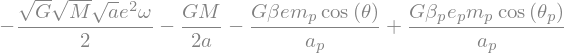

In [105]:
H_expr = - G*M/(2*a) - Rational(1,2)*sqrt(G*M*a)*e**2*om + G*mp/ap*bp*ep*cos(thp) - G*mp/ap*b*e*cos(th)
H_expr

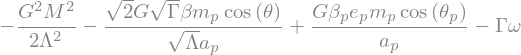

In [106]:
H = H_expr.subs(
    {
        Rational(1, 2) * sqrt(G * M * a) * e**2: Gam,
        e: sqrt(2 * Gam / Lam),
        a: Lam**2 / (G * M),
    }
)
H = term_simplify(H)
H

In [107]:
def diff(expr, var):
    run = expr.diff(var)
    for key in EXPRS.keys():
        run += expr.diff(key)*EXPRS[key].diff(var)
    return(run)

Right now, keeping ALL terms, and removing $\mathcal O(\mu_p^2)$ in the Latex document

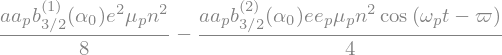

In [108]:
R = mup*n**2*a**2*Rational(1,8)*(ap/a)*b1_3_2*e**2 - mup*n**2*a**2*Rational(1,4)*(ap/a)*b2_3_2*e*ep*cos(omp*t-pom)
R

# $\dot \Lambda$

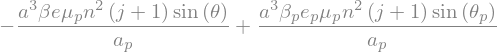

In [109]:
Lamdot = (
    -diff(H, l)
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
Lamdot

# $\dot n$

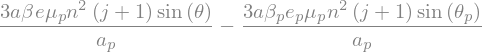

In [110]:
ndot = term_multiply(Lamdot, -3 * n**2 * a / (G * M))
ndot = (
    ndot.subs({sqrt(2 * Gam / Lam): e})
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
ndot

# $\dot a$

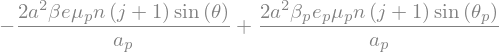

In [111]:
adot = term_multiply(Lamdot, 2/(n*a))
adot

# $\dot \Gamma$

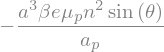

In [112]:
Gamdot = (
    diff(H, pom)
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
Gamdot

# $\dot e$

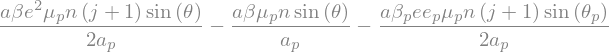

In [113]:
edot = Gamdot/(Lam*e) - term_multiply(Lamdot, Rational(1,2)/Lam*e)
edot = edot.subs({sqrt(2*Gam/Lam):e})
edot = edot.subs({Lam:sqrt(G*M*a)}).subs({sqrt(G*M):n*a**Rational(3,2)})
edot

# $\dot \varpi$

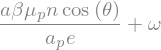

In [114]:
pomdot = (
    (-diff(H, Gam))
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
pomdot

# $\dot \lambda$

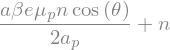

In [115]:
ldot = (
    diff(H, Lam)
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)

ldot

# $\dot \theta_p$

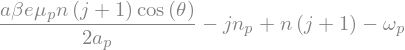

In [116]:
thpdot = term_multiply(ldot,(j+1)) - j*np - omp
thpdot

In [117]:
print(latex(thpdot))

\frac{a \beta e \mu_{p} n \left(j + 1\right) \cos{\left(\theta \right)}}{2 a_{p}} - j n_{p} + n \left(j + 1\right) - \omega_{p}


# $\ddot\lambda$

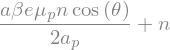

In [118]:
ldot

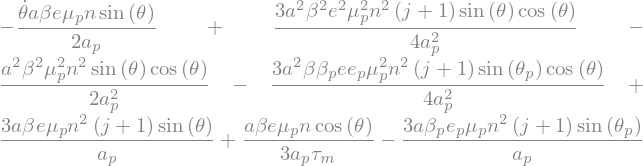

In [119]:
lddot = (
    (
        diff(ldot, th) * dth 
        +term_multiply(adot,diff(ldot, a))
        +term_multiply(edot,diff(ldot, e))
        +term_multiply(ndot,diff(ldot, n).args[0])
        +term_multiply(ndot,diff(ldot, n).args[1])
        +diff(ldot,ap)*(-2*ap/(3*tm))
    )
) 
lddot

In [120]:
#lddot = (lddot + O(mup**2)).removeO() # first order in mu_p since theres not 1/e terms
#lddot

# $\ddot\varpi$

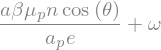

In [121]:
pomdot

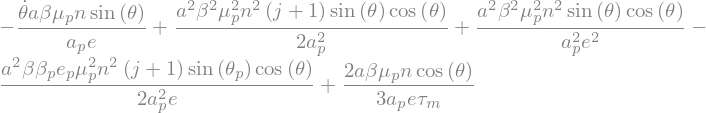

In [122]:
pomddot = (
    (
        diff(pomdot, th) * dth 
        +term_multiply(adot,diff(pomdot, a))
        +term_multiply(edot,diff(pomdot, e))
        +term_multiply(ndot,diff(pomdot, n))
        +diff(pomdot,ap)*(-2*ap/(3*tm))
    )
) 
pomddot

# $\ddot\theta_p$

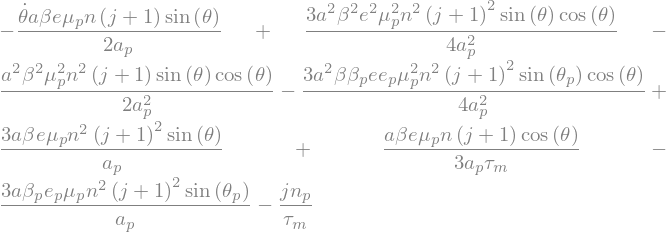

In [123]:
thpddot = term_multiply(lddot,(j+1)) - j*np/tm
thpddot

In [124]:
print(latex(thpddot.subs(a/ap,alpha**(-1))))

- \frac{\dot\theta \beta e \mu_{p} n \left(j + 1\right) \sin{\left(\theta \right)}}{2 \alpha} - \frac{j n_{p}}{\tau_{m}} + \frac{3 \beta e \mu_{p} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta \right)}}{\alpha} + \frac{\beta e \mu_{p} n \left(j + 1\right) \cos{\left(\theta \right)}}{3 \alpha \tau_{m}} - \frac{3 \beta_{p} e_{p} \mu_{p} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta_{p} \right)}}{\alpha} + \frac{3 \beta^{2} e^{2} \mu_{p}^{2} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta \right)} \cos{\left(\theta \right)}}{4 \alpha^{2}} - \frac{\beta^{2} \mu_{p}^{2} n^{2} \left(j + 1\right) \sin{\left(\theta \right)} \cos{\left(\theta \right)}}{2 \alpha^{2}} - \frac{3 \beta \beta_{p} e e_{p} \mu_{p}^{2} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta_{p} \right)} \cos{\left(\theta \right)}}{4 \alpha^{2}}


# $\ddot\theta$

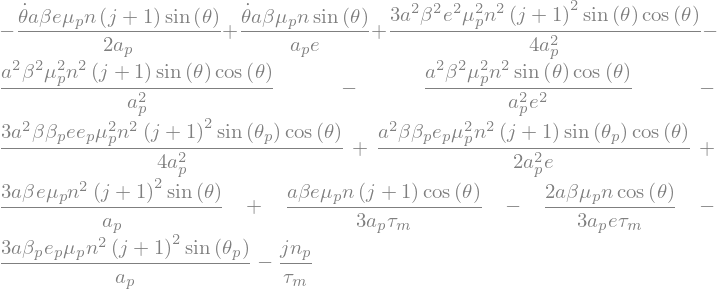

In [125]:
thddot = thpddot - pomddot
thddot

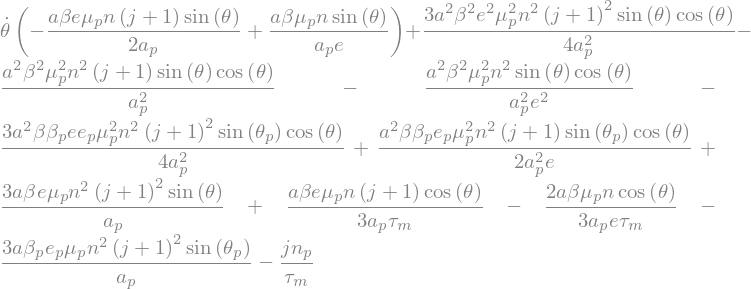

In [126]:
thddot.collect(dth)

# $\dot\varpi_{\rm sec}$

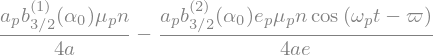

In [127]:
pomdsec = term_multiply(diff(R,e),1/(n*a**2*e))
pomdsec

# $\dot e_{\rm sec}$

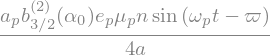

In [128]:
edsec = -diff(R,pom)/(n*a**2*e)
edsec

# Solutions to algebraic $\dot X, \dot P = 0$ equations

Using units $n=1$

In [ ]:
soln = ndot.subs({ap:alpha*a,n:1})
soln

In [ ]:
sole = edot.subs({ap:alpha*a,n:1})
sole

In [ ]:
solpom = pomdot.subs({ap:alpha*a,n:1})
solpom

In [ ]:
solthp = thpdot.subs({ap:alpha*a,n:1,np:alpha**Rational(-3,2)})
solthp

In [ ]:
solth = solthp + omp - solpom
solth

In [ ]:
params = {
    j: 2,
    om: 0,
    omp: 0,
    mup: 1e-3,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    alpha: 0.7631428283688879-0.001,
    ep: 0.01
}
funs = [iterfun.subs(params) for iterfun in [soln, sole, solthp]]

In [ ]:
funs

In [ ]:
xp = [e,thp,th]

In [ ]:
funcl = lambdify(xp,funs)
def func(x0):
    return(funcl(*x0))

In [ ]:
func([0.01,0.764,0.9*npy.pi])

In [ ]:
jacs = []
for fun in funs:
    run = []
    for xit in xp:
        run += [fun.diff(xit)]
    jacs += [run]
jacs

In [ ]:
jacl = lambdify(xp,jacs)
def jac(x0):
    return(jacl(*x0))

In [ ]:
jac([0.01,0.764,0.9*npy.pi])

In [ ]:
sol = sp.optimize.root(func, [0.001,1.,2.], method="krylov", jac=jac, tol=1e-12)
sol

In [ ]:
sol.x[2] / npy.pi

# Right hand side for numerical integrations

In [ ]:
Eq(np,exp(-t/tm))

In [ ]:
TMVAL = 2 * npy.pi * 1e6
convs = {}
convs = {ap: n ** Rational(2, 3) / np ** Rational(2, 3) * a, th: thp + omp * t - pom}
params = {}
params = {
    j: 2,
    mup: 5e-5,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    #ep: 0.1,
    b1_3_2: 9.222398400061197,
    b2_3_2: 8.002091900497529,
}

alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
#params[omp] = 0
#params[om] = params[omp] * alpha0val**3.5


funs = [
    iterfun.subs(convs).subs(params)
    for iterfun in [ndot, edot + edsec, pomdot + pomdsec, thpdot]
]
funs

In [ ]:
xp = [n, e, pom, thp, np, t]

In [ ]:
lambdastr(xp, funs).replace("math", "npy")

In [ ]:
funcl = lambdify(xp, funs)


def func(t, x0):
    npval = npy.exp(-t/TMVAL)
    #npval = 1 - t / TMVAL
    return funcl(*x0, npval, t)

In [ ]:
teval = npy.linspace(0, 2 * npy.pi * 7.5e5, 10000)
sol = sp.integrate.solve_ivp(
    func,
    [teval[0], teval[-1]],
    [1/1.55, 0.001, 1, 2],
    t_eval=teval,
    rtol=1e-9,
    #atol=1e-9,
    method="DOP853",
)

In [ ]:
fig, ax = plt.subplots()
#ax.plot(sol.t,sol.y[0,:])
ax.plot(sol.t,sol.y[0,:]/npy.exp(-sol.t/TMVAL))
#ax.plot(sol.t,sol.y[1,:])
#ax.scatter(sol.t,sol.y[2,:]%(2*npy.pi))
#ax.scatter(sol.t,sol.y[3,:]%(2*npy.pi))
#ax.scatter(sol.t,(sol.y[3,:]+params[omp]*sol.t-sol.y[2,:])%(2*npy.pi))

# Grid of capture outcomes

In [129]:
with open("results_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5.pkl", "rb") as f:
    jobs, results = pickle.load(f)

(558, 0.095, 0.0, 0.0)
(475, 0.08, 4.8634927841792366e-05, 1.888289905175526e-05)
(490, 0.08, 0.0006789879531914857, 0.0002636224940886073)


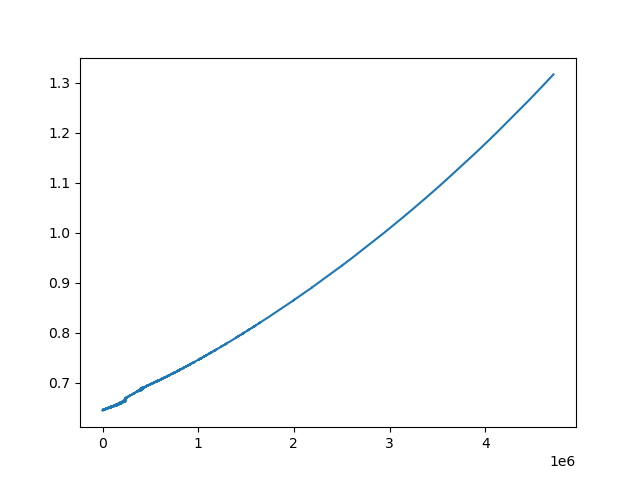

In [148]:
fig, ax = plt.subplots()
ind = 465 + 3*31
print(jobs[ind])
ax.plot(results[ind].t,results[ind].y[0,:]/npy.exp(-results[ind].t/TMVAL))
#ax.scatter(results[ind].t,(results[ind].y[3,:]+jobs[ind][2]*results[ind].t-results[ind].y[2,:])%(2*npy.pi))
ind = 475 #+ 4*31
print(jobs[ind])
#ax.plot(results[ind].t,results[ind].y[0,:]/npy.exp(-results[ind].t/TMVAL))
#ax.scatter(results[ind].t,(results[ind].y[3,:]+jobs[ind][2]*results[ind].t-results[ind].y[2,:])%(2*npy.pi))
ind = 490 #+ 4*31
print(jobs[ind])
#ax.plot(results[ind].t,results[ind].y[0,:]/npy.exp(-results[ind].t/TMVAL))
#ax.scatter(results[ind].t,(results[ind].y[3,:]+jobs[ind][2]*results[ind].t-results[ind].y[2,:])%(2*npy.pi))


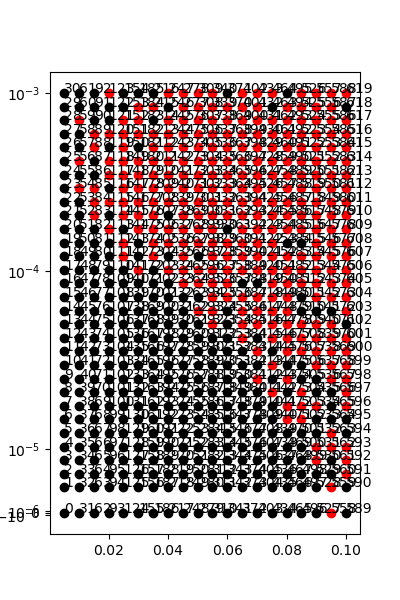

In [149]:
fig, ax = plt.subplots(figsize=(4,6))
for ind, result in enumerate(results):
    params = jobs[ind]
    nRatio = results[ind].y[0,-1]/npy.exp(-results[ind].t[-1]/TMVAL)
    if nRatio > 0.8:
        ax.scatter(params[1],params[2]-params[3],c="r")
    else:
        ax.scatter(params[1],params[2]-params[3],c="k")
    ax.text(params[1],params[2]-params[3],f"{ind}")
ax.set_yscale("symlog",linthresh=5e-6,linscale=0.05)

In [156]:
119,105
305,291
491,477